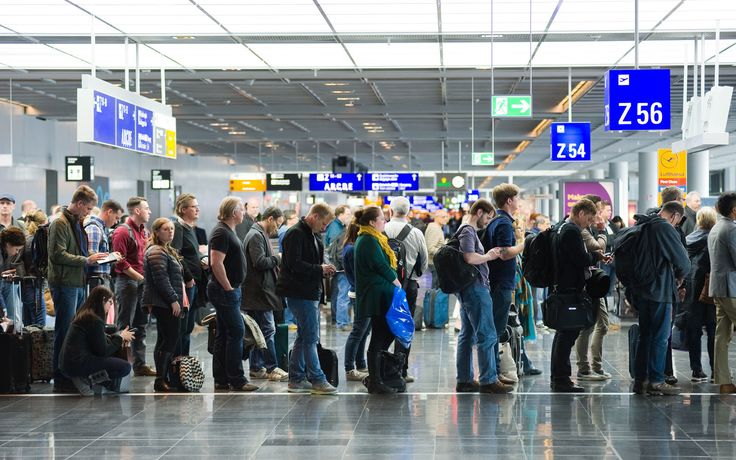

# Predict customer buying behavior (British Airways)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
BA_data = pd.read_csv('customer_booking.csv', encoding = 'ISO-8859-1')
BA_data

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


In [4]:
# Drop duplicates values
BA_data.drop_duplicates(inplace = True)

In [6]:
BA_data.shape

(49281, 14)

In [7]:
BA_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49281 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         49281 non-null  int64  
 1   sales_channel          49281 non-null  object 
 2   trip_type              49281 non-null  object 
 3   purchase_lead          49281 non-null  int64  
 4   length_of_stay         49281 non-null  int64  
 5   flight_hour            49281 non-null  int64  
 6   flight_day             49281 non-null  object 
 7   route                  49281 non-null  object 
 8   booking_origin         49281 non-null  object 
 9   wants_extra_baggage    49281 non-null  int64  
 10  wants_preferred_seat   49281 non-null  int64  
 11  wants_in_flight_meals  49281 non-null  int64  
 12  flight_duration        49281 non-null  float64
 13  booking_complete       49281 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.6+ MB


### Define numerical and categorical columns

In [8]:
numerical_cols =  ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration']
categorical_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']

# cap outliers for numerical columns 
for i in ['purchase_lead', 'length_of_stay']:
    cap = BA_data[i].quantile(0.99)
    BA_data[i] = BA_data[i].clip(upper = cap)

### Define preprocessing pipelines

In [9]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
])

In [10]:
numerical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [11]:
categorical_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

### Combine preprocessing steps

In [12]:
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
], remainder = 'passthrough')

In [13]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['num_passengers', 'purchase_lead',
                                  'length_of_stay', 'flight_hour',
                                  'flight_duration']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sales_channel', 'trip_type', 'flight_day',
                                  'route', 'booking_origin'])])

### Independent & Dependent columns

In [14]:
X = BA_data.drop('booking_complete', axis = 1)
y = BA_data['booking_complete']

In [15]:
# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Define classifiers

In [16]:
models = {
    'Random Forest' : RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True, class_weight=None, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.3, subsample=1, colsample_bytree=1, gamma=0, reg_alpha=0, reg_lambda=1, use_label_encoder=False, random_state=42)
}

### Evaluate models
- RandomForestClassifier
- XGBClassifier

In [17]:
Models_details = []
features_importance = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

    cv_scores = cross_val_score(pipeline, X, y, cv = 5, scoring = 'f1')

    Models_details.append({
        'Model' : model_name,
        'Accuracy' : accuracy,
        'Precision' : precision,
        'Recall' : recall,
        'F1-Score' : f1,
        'Roc-Auc' : roc_auc,
        'CV F1 Mean' : cv_scores.mean()
    })

    # Extract feature 
    model_fitted = pipeline.named_steps['classifier']
    if hasattr(model_fitted, 'feature_importances_'):
        ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        ohe_features = ohe.get_feature_names_out(categorical_cols)
        feature_names = numerical_cols + list(ohe_features) + list(X.columns.difference(numerical_cols + categorical_cols))
        importances = model_fitted.feature_importances_
        importance_df = pd.DataFrame({'Feature' : feature_names, 'Importance' : importances})
        importance_df = importance_df.sort_values(by = 'Importance', ascending = False).head(10)
        importance_df['Model'] = model_name
        features_importance[model_name] = importance_df

D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:29:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Anaconda3\Lib\sit

### Comparision model details

In [18]:
print("\nModel Performance Comparison:")
Models_details


Model Performance Comparison:


[{'Model': 'Random Forest',
  'Accuracy': 0.8516063577950626,
  'Precision': 0.493801652892562,
  'Recall': 0.10923217550274222,
  'F1-Score': 0.17889221556886228,
  'Roc-Auc': np.float64(0.7746897965752851),
  'CV F1 Mean': np.float64(0.09853304139583217)},
 {'Model': 'XGBoost',
  'Accuracy': 0.8514034494420021,
  'Precision': 0.4896551724137931,
  'Recall': 0.09734917733089579,
  'F1-Score': 0.16240945482272207,
  'Roc-Auc': np.float64(0.78268845822233),
  'CV F1 Mean': np.float64(0.11100448715215458)}]

### Model details in proper way

In [19]:
results_df = pd.DataFrame(Models_details).round(4)
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
           Model  Accuracy  Precision  Recall  F1-Score  Roc-Auc  CV F1 Mean
0  Random Forest    0.8516     0.4938  0.1092    0.1789   0.7747      0.0985
1        XGBoost    0.8514     0.4897  0.0973    0.1624   0.7827      0.1110


### Analyze a both model performance

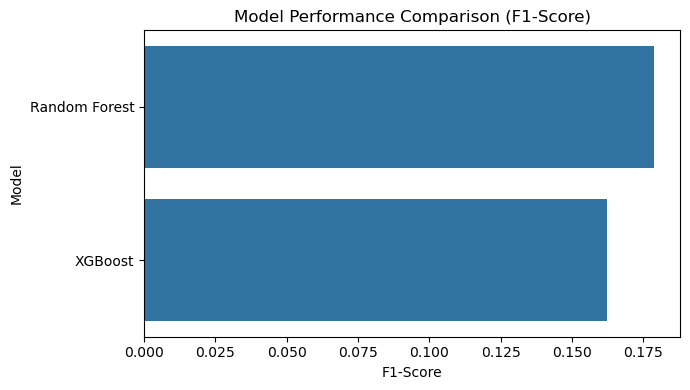

In [31]:
# Plot F1-Scores
plt.figure(figsize=(7, 4))
sns.barplot(x='F1-Score', y='Model', data=results_df.sort_values(by='F1-Score', ascending=False))
plt.title('Model Performance Comparison (F1-Score)')
plt.xlabel('F1-Score')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

- RandomForest algorithmn is the performing well on this dataset to create a well structured model.
- XGBoost performing little bit less on this dataset in comparision to RandomForest

### Top 10 Important features of `RandomForest` and `XGBoost`

In [21]:
All_feature_df = pd.concat(features_importance.values(), axis = 0)

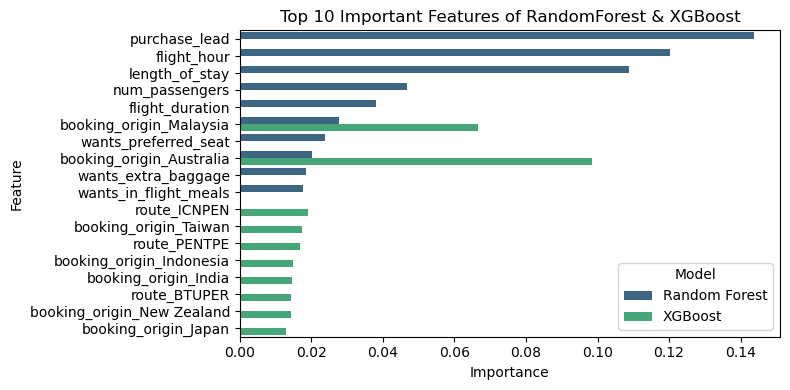

In [37]:
# Plot top features from each model
plt.figure(figsize=(8, 4))
sns.barplot(All_feature_df, x='Importance', y='Feature', hue = 'Model', palette='viridis')
plt.title(f'Top 10 Important Features of RandomForest & XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Feature importance summary 
The chart display the top 10 most influential features indentified by two classification models --- **Random Forest** and **XGBoost** --- in predicting customer behavior(likely related to booking or delay prediction).

- Random Forest :-
  - `purchase_lead`, `flight_hour` and `length_of_stay` are the most critical predictors, indicating the importance of timing and trip duration in customer decisions.
  - `num_passengers` and `flight_duration` also rank high, showing how group size and travel_time influence behavior.


- XGBoost :-
  - Places significant importance on `booking_origin`, especially from countries like `Australia`, `Malaysia`, and `Taiwan`, indicating geographic location as a strong determinant.
  - Specific routes (e.g., `ICNPEN`, `PENTPE`, `BTUPER`) also emerge as key features, suggesting route popularity or operational efficiency may influence the target behavior.